# WiDS 2025
### Sex Patterns in ADHD

### Import

In [1]:
import pandas as pd
import numpy as np
import math


from sklearn.compose import ColumnTransformer
from sklearn.linear_model import MultiTaskElasticNetCV, LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline, Pipeline


import seaborn as sns
import matplotlib.pyplot as plt

# Multi-output
from sklearn.multioutput import MultiOutputClassifier

# Multi-task
from sklearn.linear_model import MultiTaskElasticNetCV


In [2]:
source = "TRAIN"
connectome_train = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_train = pd.read_csv(f"{source}/{source}_CATEGORICAL_METADATA.csv")
quan_train = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")
label = pd.read_csv(f"{source}/TRAINING_SOLUTIONS.csv")

In [3]:
source = "TEST"
connectome_test = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_test = pd.read_csv(f"{source}/{source}_CATEGORICAL.csv")
quan_test = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")

In [4]:
train = connectome_train.merge(quan_train, on= 'participant_id').merge(cat_train, on= 'participant_id')
train.head(5)

test = connectome_train.merge(quan_test, on= 'participant_id').merge(cat_test, on= 'participant_id')


In [5]:
train.set_index('participant_id',inplace=True)
test.set_index('participant_id',inplace=True)
label.set_index('participant_id',inplace=True)

In [6]:
# Explore Null data
pd.DataFrame(train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count
MRI_Track_Age_at_Scan,360
PreInt_Demos_Fam_Child_Ethnicity,11


In [7]:
# Filter out the row index of 
'''null_index = train[train.isnull().any(axis=1)].index

train = train[~train.index.isin(null_index)]
label = label[~label.index.isin(null_index)]'''

'null_index = train[train.isnull().any(axis=1)].index\n\ntrain = train[~train.index.isin(null_index)]\nlabel = label[~label.index.isin(null_index)]'

### EDA

Cleaning checklist:

Null: ?. Null Var importance? 

Each Var Normal Range -> Detect Anomalies -> remove or something else

Data Type: Check categorical to have uniformed labels. check normal range if coded. Norminal type -> one-hot-code, ordinal -> label encode ()



In [8]:
label.ADHD_Outcome.value_counts()
# 383 neg, 831 pos

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

In [9]:
label.Sex_F.value_counts()
# 797 M, 416 F

Sex_F
0    797
1    416
Name: count, dtype: int64

In [10]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'], normalize='all')

Sex_F,0,1
ADHD_Outcome,,
0,0.178071,0.136851
1,0.478978,0.206101


In [11]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'])

Sex_F,0,1
ADHD_Outcome,,
0,216,166
1,581,250


In [12]:
connectome_train.set_index('participant_id', inplace= True)

In [17]:
pd.DataFrame(train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count
MRI_Track_Age_at_Scan,248
PreInt_Demos_Fam_Child_Ethnicity,5


# Model Train
Baseline model: Multi-output pipeline for same model.
- Logistic Reg with L1 norm for sparsity and inference enhancement
- NN with 2 output nodes with binary classifier activiation function (Sigmoid)

Performance: Multi-task models with shared features for correlated tasks.
- Multitask Lasso or multitask Elastic Net

### Preprocessing
A pipeline that transform categorical into one-hot code, and quant data into a standard scaler

In [31]:
# Remove 2 features with null
train = train.drop(['MRI_Track_Age_at_Scan', 'PreInt_Demos_Fam_Child_Ethnicity'], axis = 1)
categorical_features = list(cat_train.drop(['participant_id', 'PreInt_Demos_Fam_Child_Ethnicity'], axis= 1).columns)
numeric_features = train.drop(cat_train.drop(['participant_id', 'PreInt_Demos_Fam_Child_Ethnicity'], axis = 1).columns, axis = 1).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

### Train - test split


In [34]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state=527)


In [35]:
pd.DataFrame(x_train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count


In [36]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(849, 19925)
(364, 19925)
(849, 2)
(364, 2)


### Visual call-out Functions

In [37]:
def model_result(y_test, y_pred, model_name):
    """
    Compute and display important performance metrics for a classification model, 
    including F1-score, sensitivity, specificity, and a confusion matrix heatmap.

    Parameters:
    -----------
    y_test : array-like or Series (Truth)
    y_pred : array-like or Series (Model prediction)
    model_name : str

    Outputs:
    --------
    - Prints the F1-score, sensitivity (recall), and specificity.
    - Displays a heatmap of the confusion matrix for easier interpretation.

    Usage:
    ------
    1. Pass `y_test` and `y_pred` as arrays (or pandas Series).
    2. Provide a descriptive `model_name`(model and dataset used) to label the confusion matrix plot.
    """
    classes = ['Negative', 'positive']
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Compute confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate sensitivity and specificity
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    # Print results
    print('Accuracy: ', accuracy)
    print(f"Sensitivity (Recall/True Positive Rate): {sens:.2f}")
    print(f"Specificity (True Negative Rate): {spec:.2f}")
    print('f1: ', f1_score(y_test, y_pred))

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix of {model_name}")
    plt.show()

### Logistic Regression for each task

In [44]:
y_train.iloc[:,0]

participant_id
IVBGlPAg0Qkn    1
3X8Ls6i8z0HW    1
v0VdBXIGO3HA    1
aUlfLwhZqquP    1
4cwPd7JVlpF5    1
               ..
zmxGvIrOD0bt    0
8PDoPj2DoJRn    1
3Av3C2ajuKHa    1
IMJWcBNrTUbI    1
UgVdu7yCx191    1
Name: ADHD_Outcome, Length: 849, dtype: int64

In [46]:
y_test

,ADHD_Outcome,Sex_F
participant_id,,
yPqk7RmP36lu,1,0
S8a4pIeq9Ay6,1,1
vf1akUdbv0FE,0,1
kawulA88OFSQ,1,0
8Ro2MJOI8nC1,1,0
...,...,...
um0Awu6Rmi05,0,1
H9EU0xUEI4QX,1,1
04X1eiS79T4B,0,1


In [ ]:
y

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', (LogisticRegression(penalty='l1', solver='liblinear')))
])

pipeline.fit(x_train, y_train.iloc[:,0])
log_reg = pipeline.named_steps['classifier']
y_pred = pipeline.predict(x_test)
f1 = f1_score(y_test.iloc[:,0],y_pred, average = 'micro')
print(f'f1 score of ADHD Log Regression with L1 : {f1:.2f}')
model_result(y_test['ADHD_Outcome'], y_pred, "ADHD Classifier with Log L1")

In [ ]:
coefficients = log_reg.coef_[0]  # Coefficients for the single task
feature_names = x_train.columns

# Combine coefficients with feature names
coef_data = list(zip(feature_names, coefficients))

sorted_coef = sorted(coef_data, key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_values = zip(*sorted_coef)

# Print sorted coefficients (due to large amount of var, wont produce chart at this time)
print("Sorted Coefficients:")
for feature, coef in sorted_coef:
    print(f"{feature}: {coef:.4f}")

f1 score of Sex Log Regression with L1 : 0.60
Accuracy:  0.5961538461538461
Sensitivity (Recall/True Positive Rate): 0.23
Specificity (True Negative Rate): 0.80
f1:  0.2898550724637681


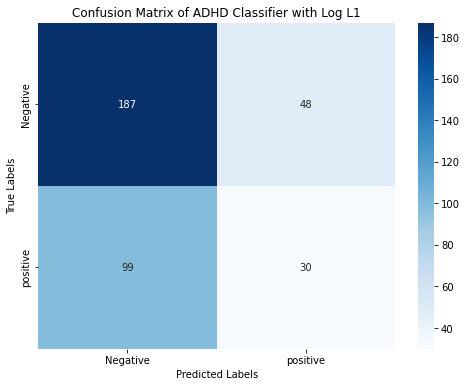

Sorted Coefficients:
18throw_189thcolumn: -0.3865
67throw_116thcolumn: 0.3506
9throw_49thcolumn: -0.3452
85throw_182thcolumn: 0.3337
4throw_195thcolumn: -0.3301
75throw_184thcolumn: 0.3161
136throw_154thcolumn: -0.3034
64throw_73thcolumn: 0.2826
67throw_75thcolumn: -0.2824
133throw_156thcolumn: 0.2821
48throw_141thcolumn: 0.2760
39throw_189thcolumn: 0.2682
12throw_89thcolumn: 0.2642
125throw_158thcolumn: 0.2566
91throw_181thcolumn: -0.2552
56throw_120thcolumn: 0.2540
91throw_105thcolumn: 0.2525
88throw_129thcolumn: 0.2480
21throw_29thcolumn: -0.2432
6throw_12thcolumn: 0.2357
59throw_62thcolumn: 0.2356
120throw_192thcolumn: 0.2326
70throw_123thcolumn: -0.2305
43throw_64thcolumn: 0.2288
4throw_158thcolumn: -0.2286
34throw_124thcolumn: -0.2285
108throw_185thcolumn: 0.2284
12throw_158thcolumn: -0.2250
45throw_178thcolumn: -0.2212
81throw_163thcolumn: -0.2157
144throw_188thcolumn: -0.2143
27throw_65thcolumn: -0.2140
82throw_97thcolumn: 0.2132
69throw_129thcolumn: 0.2126
72throw_186thcolumn:

In [58]:
pipeline.fit(x_train, y_train.iloc[:,1])
log_reg = pipeline.named_steps['classifier']
y_pred = pipeline.predict(x_test)
f1 = f1_score(y_test.iloc[:,1],y_pred, average = 'micro')
print(f'f1 score of Sex Log Regression with L1 : {f1:.2f}')
model_result(y_test['Sex_F'], y_pred, "ADHD Classifier with Log L1")

coefficients = log_reg.coef_[0]  # Coefficients for the single task
feature_names = x_train.columns

# Combine coefficients with feature names
coef_data = list(zip(feature_names, coefficients))

sorted_coef = sorted(coef_data, key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_values = zip(*sorted_coef)

# Print sorted coefficients (due to large amount of var, wont produce chart at this time)
print("Sorted Coefficients:")
for feature, coef in sorted_coef:
    print(f"{feature}: {coef:.4f}")

### Multi-output
Perform the same model for both tasks

In [59]:
# Multi-output model for log classifier with 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(penalty='l1', solver='liblinear')))
])

pipeline.fit(x_train, y_train)

model = pipeline.named_steps['classifier']

y_pred = pipeline.predict(x_test)
f1 = f1_score(y_test,y_pred, average = 'micro')
print(f'f1 score of Multi-output Log Regression with L1 : {f1:.2f}')


f1 score of Multi-output Log Regression with L1 : 0.62


Looking closer into each classes metrics

Accuracy:  0.6043956043956044
Sensitivity (Recall/True Positive Rate): 0.80
Specificity (True Negative Rate): 0.17
f1:  0.7352941176470589


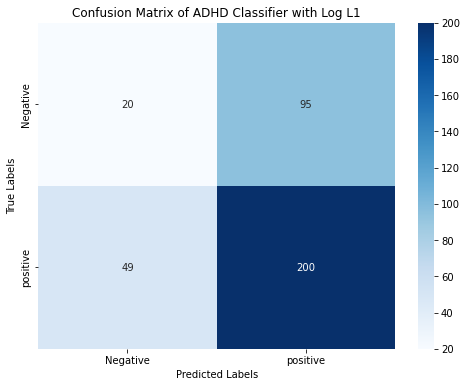

In [39]:
model_result(y_test['ADHD_Outcome'], y_pred[:,0], "ADHD Classifier with Log L1")

Log while produce about less then 0.6 acc for both classes which is a bit over random guess, it produce extremely low f1 score for Gender.

### Multi-task Models
